In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython import display

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0') # so we can do .to(device)
else:
    device = torch.device('cpu')

# Value Iteration

Value iteration is a method to solve for the optimal policy in Markov Decision Process by iteratively updating the value of each state. The algorithm for value iteration is shown below:

<figure>
  <div style="text-align:center;">
  <img src="assets/05/value_iteration_algo.png", width = 450>
  <figcaption>Source: Richard S. Sutton and Andrew G. Barto. Reinforcement Learning: An Introduction.</figcaption>
  </div>
</figure>

In this example, we will use the cartpole environment from OpenAI gym. The states of this environment are cartpole position $x$, cartpole velocity $\dot{x}$, pole angle $\theta$, and pole angular velocity $\dot{\theta}$. 

<figure>
  <div style="text-align:center;">
  <img src="assets/05/cartpole.png", width = 300>
  </div>
</figure>

The episode is done when:
- $x$ < -env.x_threshold or $x$ > env.x_threshold
- $\theta$ < -env.theta_threshold_radians or $\theta$ > env.theta_threshold_radians

The reward is 0 when the episode is done, otherwise the rewards is +1. In other words, we want the agent to keep the cartpole and pole within the range of desired states as long as possible.

We're not actually going to run this until it converges because it will take too much time. However, it is still interesting to see how one can implement value iteration to solve this environment so we can understand and appreciate the challenges.

In [5]:
env = gym.make('CartPole-v1')

In [6]:
class ModifiedCartpoleEnv(gym.envs.classic_control.CartPoleEnv):
    def __init__(self, render_mode):
        super().__init__(render_mode)
    def reset(self, state=None):
        """
        Modify reset function so we can teleport to any particular states if we want to.
        """
        if state is not None:
            self.state = state
        else:
            self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

In [7]:
env = ModifiedCartpoleEnv(render_mode="rgb_array")
state = env.reset()

Value iteration requires us to compute the value of all $s \in S$. Practically, we need to discretize the state and action space to do this.

In [8]:
# Define number of possible states and range for each states
n_x, x_min, x_max = 5, -env.x_threshold, env.x_threshold
n_x_dot, x_dot_min, x_dot_max = 5, -8.0, 8.0 # actually from -inf to +inf
n_theta, theta_min, theta_max = 5, -env.theta_threshold_radians, env.theta_threshold_radians
n_theta_dot, theta_dot_min, theta_dot_max = 5, -10.0, 10.0 # actually from -inf to +inf 

In [9]:
# States
x_range = np.linspace(x_min, x_max, num = n_x)
x_dot_range = np.linspace(x_dot_min, x_dot_max, num = n_x_dot)
theta_range = np.linspace(theta_min, theta_max, num = n_theta)
theta_dot_range = np.linspace(theta_dot_min, theta_dot_max, num = n_theta_dot)

# Actions
u_range = (0,1)

# Create meshgrid
x_v, x_dot_v, theta_v, theta_dot_v = np.meshgrid(x_range, x_dot_range, theta_range, theta_dot_range)

In [10]:
# Create list of list with all possible states
states = []
for i in range(n_x):
    for j in range(n_x_dot):
        for k in range(n_theta_dot):
            for l in range(n_theta):
                s = np.array([x_v[i,j,k,l], x_dot_v[i,j,k,l], theta_v[i,j,k,l], theta_dot_v[i,j,k,l]])
                states.append(s)

In [11]:
def discretize_state(state):
    """
    Function to discretize state into the range we specified above.
    NOTE: (x_range, x_dot_range, theta_range, theta_dot_range) are defined globally in this notebook.
    """
    
    x = state[0]
    x_dot = state[1]
    theta = state[2]
    theta_dot = state[3]
    discretized_x = x_range[np.argmin(abs(x - x_range))] 
    discretized_x_dot = x_dot_range[np.argmin(abs(x_dot - x_dot_range))]
    discretized_theta = theta_range[np.argmin(abs(theta - theta_range))]
    discretized_theta_dot = theta_dot_range[np.argmin(abs(theta_dot - theta_dot_range))]
    discretized_state = np.array([discretized_x, 
                                  discretized_x_dot, 
                                  discretized_theta, 
                                  discretized_theta_dot])
    return discretized_state

def get_state_index(states, discretized_state):
    """
    Function to map the discretized_state onto its corresponding index in states.
    """
    
    diff = states - discretized_state
    flags = np.any(diff, axis=1)
    idx = np.where(flags==False)[0][0]
    return idx

In [12]:
convergence_threshold = 0.01
delta = 100000
gamma = 0.99
deltas = []
V = np.zeros(n_x * n_x_dot * n_theta * n_theta_dot) # initialize V(s) = 0 for all states

num_iter = 0
while delta > convergence_threshold:
    delta = 0
    for i in range(len(states)): # for each possible state
        state = states[i]
        v = V[i] # value of current state
        V_max = -999999999
        for u in u_range: # evaluate all possible actions (due to V(s) <- max_a ...)
            env.reset(state = state) # make sure we are at state = state
            next_state, r, terminated, truncated, _  = env.step(u) # apply u for one step
            discretized_next_state = discretize_state(next_state)
            next_state_index = get_state_index(states, discretized_next_state)
            value = r + gamma * V[next_state_index]
            if value > V_max:
                V_max = value
        V[i] = V_max # update value of current state
        delta = max(delta, abs(v - V_max)) # update delta for convergence check
    deltas.append(delta)
    num_iter+=1
    if num_iter % 10 == 0:
        print('num_iter: ', num_iter, ' --- delta: ', delta)
print('Value iteration converged after %d iterations' % num_iter)

/usr/local/lib/python3.8/dist-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


num_iter:  10  --- delta:  0.9135172474836413
num_iter:  20  --- delta:  0.826168623835585
num_iter:  30  --- delta:  0.7471720943315958
num_iter:  40  --- delta:  0.6757290490602799
num_iter:  50  --- delta:  0.6111172395328666
num_iter:  60  --- delta:  0.5526834771623825
num_iter:  70  --- delta:  0.4998370298991972
num_iter:  80  --- delta:  0.4520436502664751
num_iter:  90  --- delta:  0.4088201744225515
num_iter:  100  --- delta:  0.36972963764972633
num_iter:  110  --- delta:  0.3343768568899179
num_iter:  120  --- delta:  0.3024044356690183
num_iter:  130  --- delta:  0.2734891510222184
num_iter:  140  --- delta:  0.24733868589386532
num_iter:  150  --- delta:  0.22368867397864278
num_iter:  160  --- delta:  0.20230002712877138
num_iter:  170  --- delta:  0.18295651830905513
num_iter:  180  --- delta:  0.1654625956647351
num_iter:  190  --- delta:  0.14964140560361727
num_iter:  200  --- delta:  0.13533300490702516
num_iter:  210  --- delta:  0.12239274379500387
num_iter:  220 

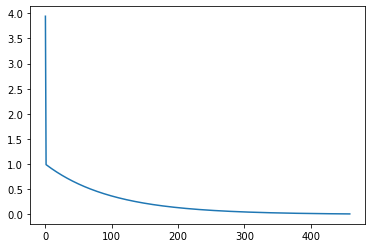

In [13]:
plt.plot(deltas)
plt.show()

Next, we need to determine how we choose an action based on $V(s)$. For example, we can do this greedily by doing:

$$
\pi(s) = \arg\max_a \sum_{s',r} p(s',r|s,a)[r + \gamma V(s')] 
$$

So, let's create another lookup table for the policy.

In [14]:
def get_best_policy(V):
    """
    Function to return the optimal policy from a given V.
    NOTE: (states, n_x, n_x_dot, n_theta_dot, n_theta, gamma) are defined globally in this notebook.
    """
    policy = np.zeros(n_x * n_x_dot * n_theta_dot * n_theta)
    for i in range(len(V)):
        state = states[i]
        V_max = -999999999
        u_max = -999999999
        for u in u_range: # evaluate all action
            env.reset(state = state) # make sure we are at state = state
            next_state, r, terminated, truncated, _  = env.step(u) # apply u for one step
            discretized_next_state = discretize_state(next_state)
            next_state_index = get_state_index(states, discretized_next_state)
            value = r + gamma * V[next_state_index]
            if value > V_max:
                V_max = value
                u_max = u
        policy[i] = u_max
    return policy

In [15]:
policy = get_best_policy(V)

Now, let's see the performance of the agent.

In [16]:
def get_action(state, policy):
    """
    Function to get what action to take according to the policy.
    NOTE: (states) is defined globally in this notebook.
    """
    discretized_state = discretize_state(state)
    state_index = get_state_index(states, discretized_state)
    u = policy[state_index]
    return u

9.0


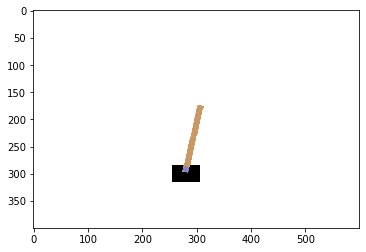

In [19]:
state = env.reset()
terminated = False
truncated = False
total_reward = 0
while not (terminated or truncated):
    action = get_action(state, policy)
    state, reward, terminated, truncated,  _ = env.step(int(action))
    total_reward += reward
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminated or truncated:
        break
print(total_reward)

From this example, we can identify several challenges:
1. If discretization is not fine enough, then applying an action may not change the state at all.
2. If discretization is too fine, then it will take a long time for the algorithm to converge.
3. As the state and action spaces get bigger, the computation needed to do value iteration increases drastically.

Now, let's take a look at REINFORCE.

In [ ]:
env.close()